In [1]:
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils import train, get_device, propagate_batch, to_plot
from snn_delays.utils.test_behavior import tb_addtask
from snn_delays.utils.visualization_utils import plot_taus
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
time_window = 50
batch_size = 128 # 128: anil kag

ckpt_dir = 'sequential_tests_24_2_25'

dataset = 'addtask_episodic'
#dataset = 'addtask' 

DL = DatasetLoader(dataset=dataset, caching='', num_workers=0, batch_size=batch_size, total_time=time_window)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
dataset_dict["time_ms"] = 2e3
#dataset_dict["time_ms"] = 50

In [3]:
structure = (50, 2)

snn = SNN(dataset_dict, structure=structure, connection_type='f', delay=(50,1), delay_type='h',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn.set_network()
snn.use_amp = False
snn.model_name = f'addask_d_50_50'
snn.input2spike_th = None
snn.num_train_samples = batch_size


[INFO] Delays: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407


In [4]:
snn_mf = SNN(dataset_dict, structure=structure, connection_type='mf', delay=None, delay_type='',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn_mf.multi_proj = 50

snn_mf.set_network()
snn_mf.use_amp = False
snn_mf.model_name = f'addask_d_50_50'
snn_mf.input2spike_th = None
snn_mf.num_train_samples = batch_size


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407


<Axes: xlabel='simulation timestep'>

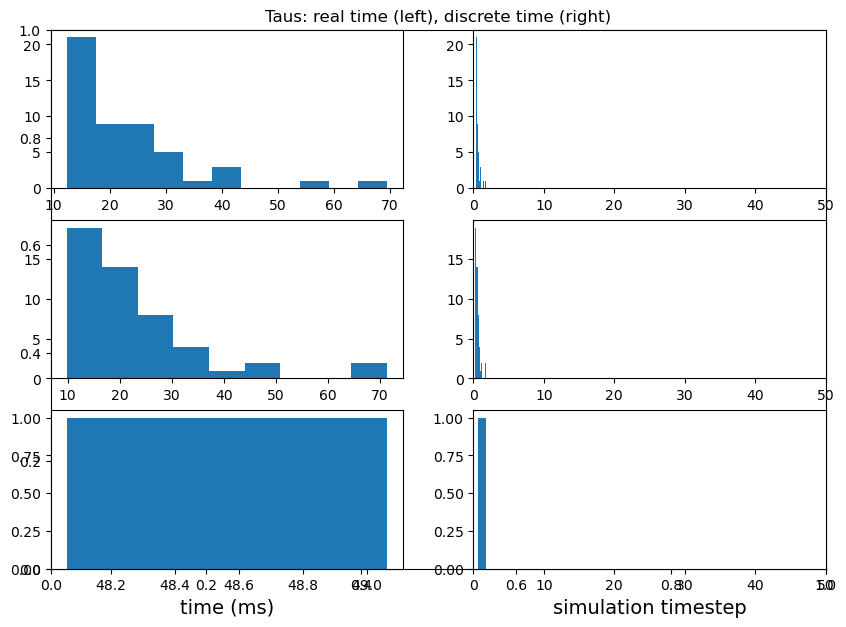

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plot_taus(snn)

<Axes: xlabel='simulation timestep'>

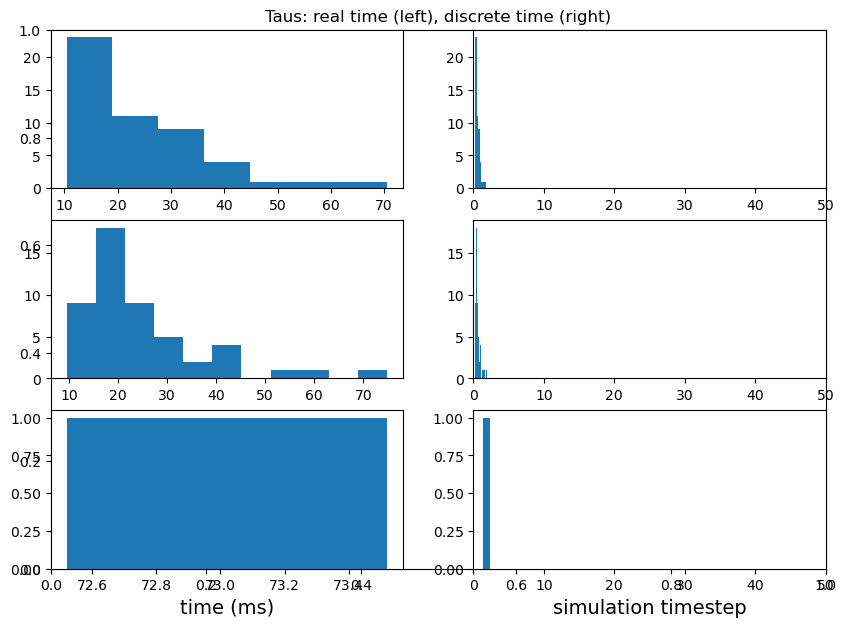

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plot_taus(snn_mf)

In [7]:
train(snn_mf, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\sequential_tests_24_2_25
Mean Error: 0.00024657713947817683% 
--------------------------


In [8]:
train(snn, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\sequential_tests_24_2_25
Mean Error: 4.6761746489210054e-05% 
--------------------------


Text(0.5, 1.0, 'train loss')

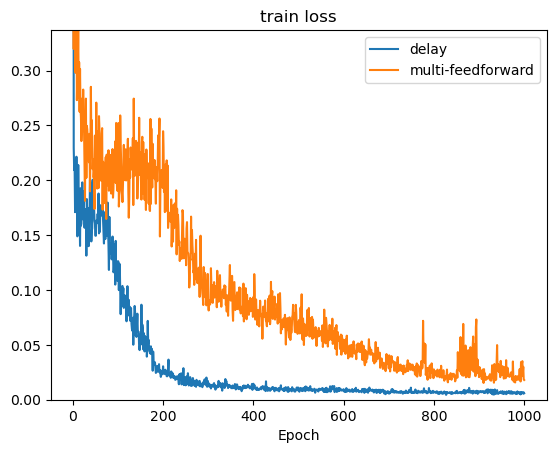

In [11]:
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
import numpy as np

loss_error = np.mean(np.array(snn.train_loss)[:,1][-100:])
plot_per_epoch(snn.train_loss, label = 'delay')
plot_per_epoch(snn_mf.train_loss, label = 'multi-feedforward')
#plt.title(f'loss error = {loss_error}')

plt.ylim(0, 50*loss_error)
plt.title('train loss')

<Axes: xlabel='simulation timestep'>

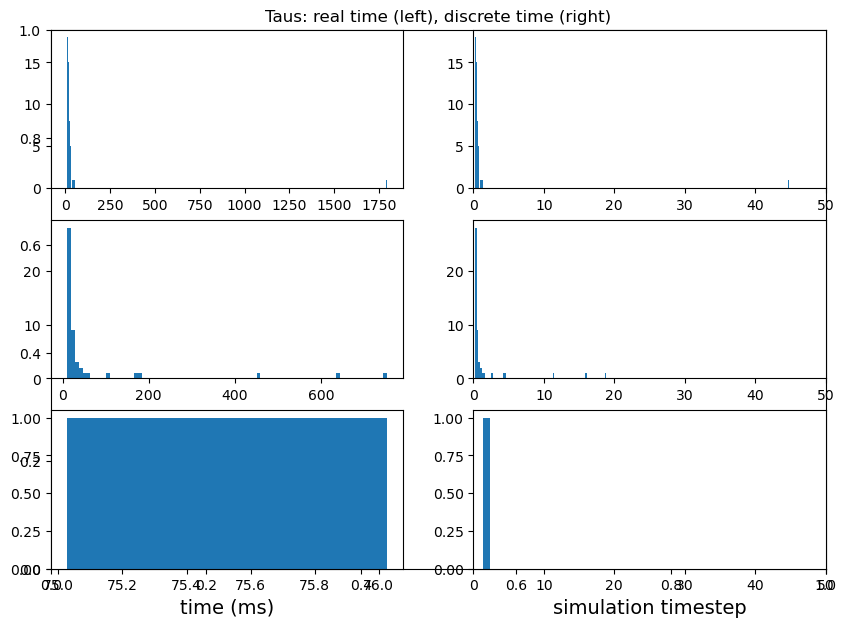

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plot_taus(snn)

<Axes: xlabel='simulation timestep'>

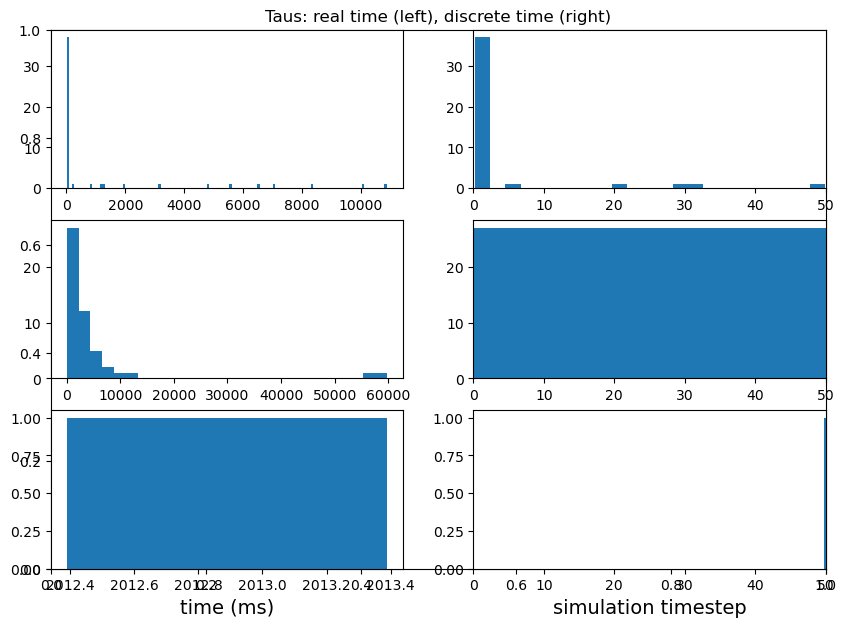

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plot_taus(snn_mf)

<Axes: xlabel='simulation timestep'>

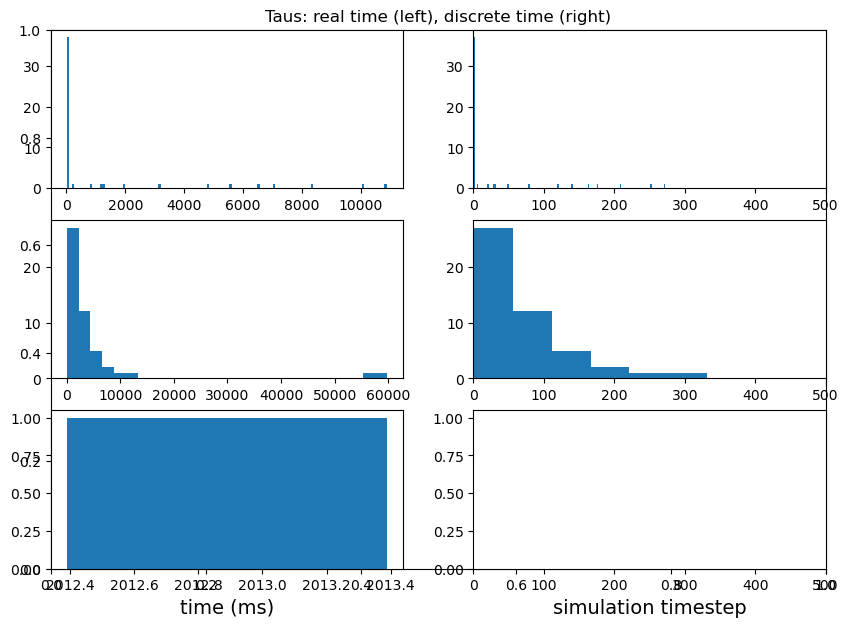

In [38]:
from snn_delays.utils.visualization_utils import plot_param
import torch

def plot_taus(snn):
    delta_t = snn.dataset_dict.get('time_ms', 0)/snn.win

    num_subplots = len(snn.tau_m_h)

    plt.title('Taus: real time (left), discrete time (right)')
    for i, pseudo_tau_m in enumerate(snn.tau_m_h):

        real_tau = -delta_t/torch.log(torch.sigmoid(pseudo_tau_m))

        plt.subplot(num_subplots, 2, 2*i+1)
        plot_param(real_tau, mode='histogram')
        if i==num_subplots-1:
            plt.xlabel('time (ms)')

        plt.subplot(num_subplots, 2, 2*i+2)
        #plot_param(real_tau/snn.win, mode='histogram')    
        plot_param(real_tau/delta_t, mode='histogram')  
        plt.xlim(0, 10*snn.win)
        
        if i==num_subplots-1:
            plt.xlabel('simulation timestep')
    return plt.gca()

plt.figure(figsize=(10,7))
plot_taus(snn_mf)

In [36]:
snn_mf.tau_m_h

[Parameter containing:
 tensor([ 5.5309,  3.4143, -2.3607, -3.1224, -1.3727, -2.0062,  4.7819, -4.5518,
         -1.3369, -1.7916, -3.5416,  1.5275, -1.2195, -0.5517,  3.8941, -2.2079,
         -3.6545, -4.9033, -3.0393, -2.7407, -0.8317, -0.6230,  4.3724,  4.9338,
         -4.3360, -2.2302, -3.9521, -4.1319,  5.6053,  5.3357, -2.3726,  5.0913,
         -4.5303, -2.5464, -3.0355, -1.1348, -0.7255, -1.4786, -3.6842, -3.5814,
          3.3927,  5.1711, -4.0993, -1.8046, -3.0988, -4.1487, -4.1670,  0.3051,
         -1.5267,  3.0099], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-6.4707,  4.6147,  4.6545,  4.5222, -5.9015,  4.5088,  4.9732, -6.1946,
         -6.3259,  5.0900,  4.6965,  5.4422, -7.9036,  4.9166,  4.5914,  7.3091,
          4.8575, -7.6741, -3.7999,  3.4623,  4.4480, -7.0226,  5.1331,  4.3364,
          4.2061, -7.4472, -3.8336, -7.4242,  4.8297, -6.8074, -6.8301, -7.2429,
          7.2671, -1.9136, -3.4851, -7.5165,  1.5632,  2.8888,  5.1526, -7.499

In [ ]:
snn_mf.tau_m_h

In [14]:
images, labels = propagate_batch(snn, test_loader)
_, labels_mf = propagate_batch(snn_mf, test_loader)

Text(0.5, 0, 'training sample')

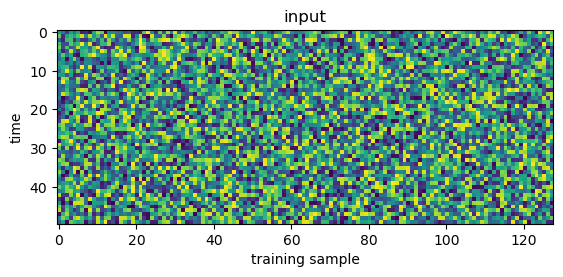

In [15]:
import matplotlib.pyplot as plt
plt.imshow(snn.spike_state['input'][:,:,0].cpu().numpy(), vmin=0, vmax=1)
plt.title('input')
plt.ylabel('time')
plt.xlabel('training sample')

Text(0.5, 0, 'training sample')

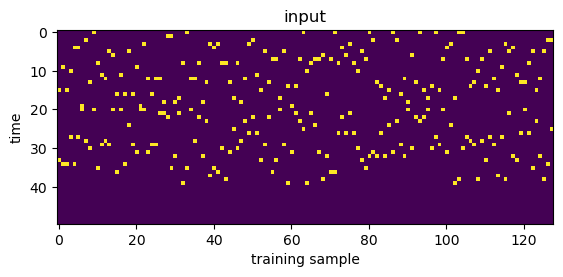

In [16]:
plt.imshow(snn.spike_state['input'][:,:,1].cpu().numpy(), vmin=0, vmax=1)
plt.title('input')
plt.ylabel('time')
plt.xlabel('training sample')

In [17]:
labels.shape

torch.Size([128, 10, 1])

0.080196515


Text(0.5, 0, 'training sample')

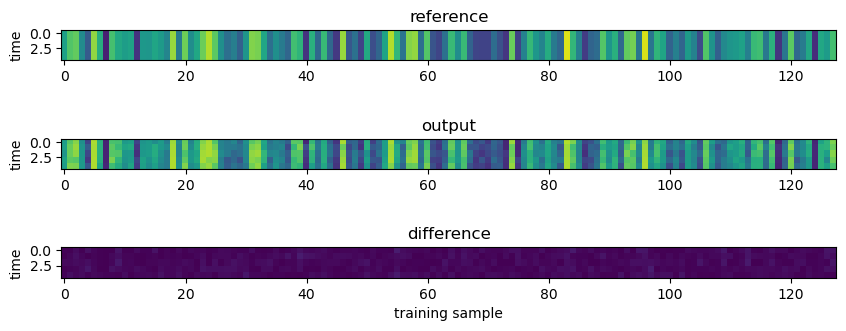

In [18]:
ref = labels[:,:5,0].T.cpu().numpy()
out = snn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()
diff = abs(ref-out[:,:,0])

import numpy as np
print(np.mean(diff))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(311)
plt.imshow(ref, vmin=0, vmax=2)
plt.title('reference')
plt.ylabel('time')

plt.subplot(312)
plt.imshow(out, vmin=0, vmax=2)
plt.title('output')
plt.ylabel('time')

plt.subplot(313)
plt.imshow(diff, vmin=0, vmax=4)
plt.title('difference')
plt.ylabel('time')
plt.xlabel('training sample')

0.080196515


Text(0.5, 0, 'training sample')

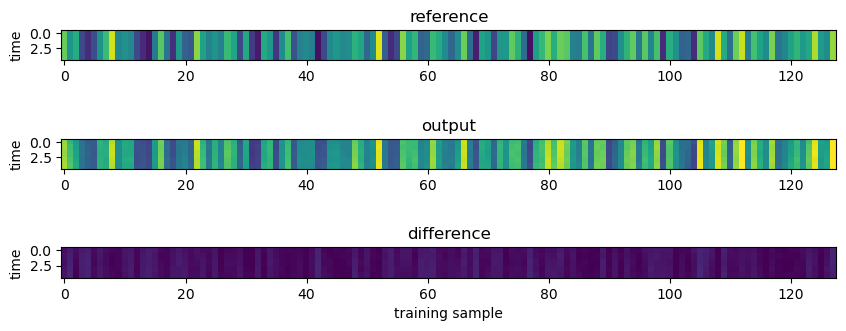

In [20]:
ref_mf = labels_mf[:,:5,0].T.cpu().numpy()
out_mf = snn_mf.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()
diff_mf = abs(ref_mf-out_mf[:,:,0])

import numpy as np
print(np.mean(diff))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(311)
plt.imshow(ref_mf, vmin=0, vmax=2)
plt.title('reference')
plt.ylabel('time')

plt.subplot(312)
plt.imshow(out_mf, vmin=0, vmax=2)
plt.title('output')
plt.ylabel('time')

plt.subplot(313)
plt.imshow(diff_mf, vmin=0, vmax=4)
plt.title('difference')
plt.ylabel('time')
plt.xlabel('training sample')

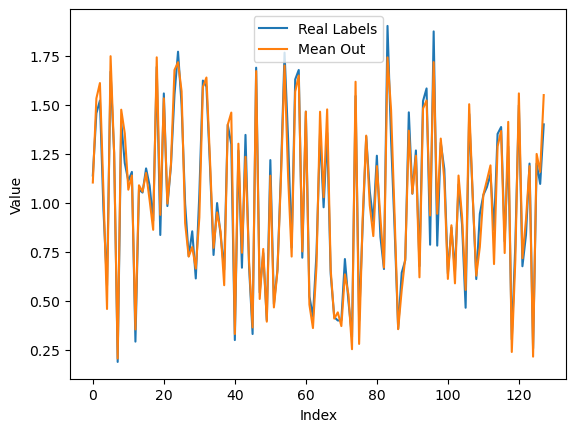

In [21]:
import numpy as np
#max_out = np.max(out, axis=0)
mean_out = np.mean(out, axis=0)

real_labels = labels[:, 0, 0]

import matplotlib.pyplot as plt
plt.plot(real_labels, label='Real Labels')
#plt.plot(max_out, label='Max Out')
plt.plot(mean_out, label='Mean Out')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

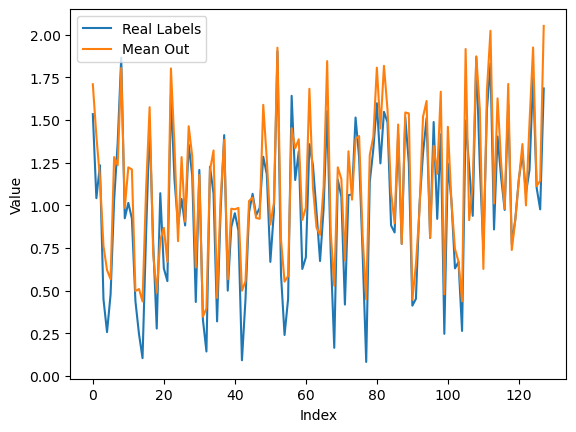

In [22]:
import numpy as np
#max_out = np.max(out, axis=0)
mean_out_mf = np.mean(out_mf, axis=0)

real_labels = labels_mf[:, 0, 0]

import matplotlib.pyplot as plt
plt.plot(real_labels, label='Real Labels')
#plt.plot(max_out, label='Max Out')
plt.plot(mean_out_mf, label='Mean Out')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

Text(0.5, 0, 'training sample')

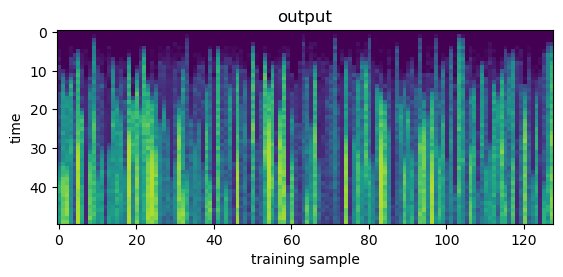

In [23]:
plt.imshow(snn.mem_state['output'].detach().cpu().numpy(), vmin=0, vmax=2)
plt.title('output')
plt.ylabel('time')
plt.xlabel('training sample')

Text(0.5, 0, 'training sample')

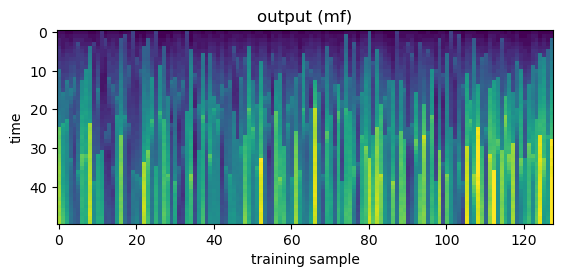

In [24]:
plt.imshow(snn_mf.mem_state['output'].detach().cpu().numpy(), vmin=0, vmax=2)
plt.title('output (mf)')
plt.ylabel('time')
plt.xlabel('training sample')

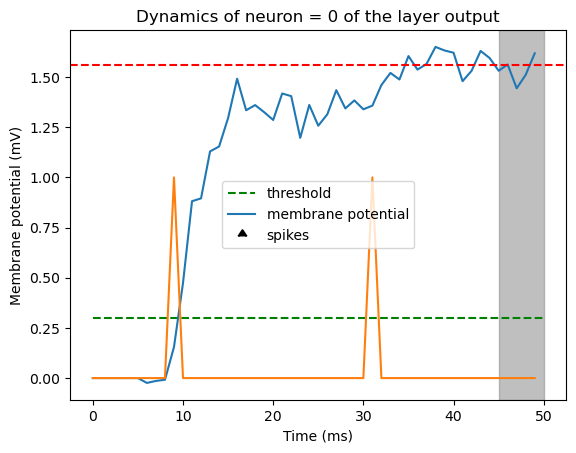

In [25]:
from snn_delays.utils.visualization_utils import visualize_activity
import numpy as np
import torch

N = np.random.randint(batch_size)
reference = torch.sum(snn.spike_state['input'][:,N,1]* snn.spike_state['input'][:,N,0]).item()

#print(snn.spike_state['input'][:,N,1])

#print(labels[N,:,0])
visualize_activity(snn, 'output', sample=N)
plt.plot(snn.spike_state['input'][:,N,1].cpu().numpy())
plt.axhline(y=reference, color='r', linestyle='--')
import matplotlib.pyplot as plt

plt.axvspan(0.9*time_window,time_window, color='gray', alpha=0.5)

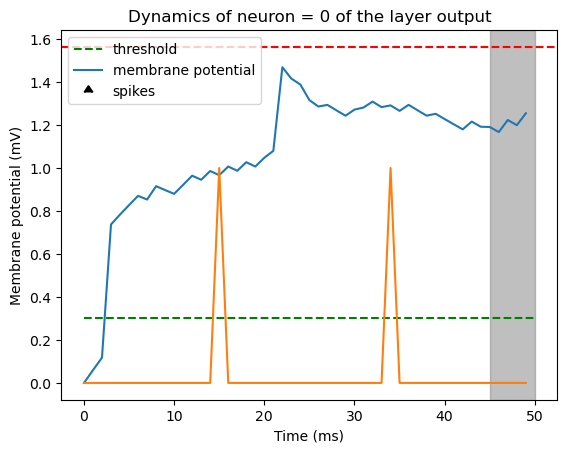

In [34]:
#N = np.random.randint(batch_size)
reference = torch.sum(snn_mf.spike_state['input'][:,N,1]* snn_mf.spike_state['input'][:,N,0]).item()

#print(snn.spike_state['input'][:,N,1])

#print(labels[N,:,0])
visualize_activity(snn_mf, 'output', sample=N)
plt.plot(snn.spike_state['input'][:,N,1].cpu().numpy())
plt.axhline(y=reference, color='r', linestyle='--')
import matplotlib.pyplot as plt

plt.axvspan(0.9*time_window,time_window, color='gray', alpha=0.5)

In [27]:
def get_errors_per_lapse(snn, num_trials):

    errors_per_lapse = [ [] for x in range(40)]

    for trial in range(num_trials):

        _, labels = propagate_batch(snn, test_loader)
        ref = labels[:,:5,0].T.cpu().numpy()
        out = snn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

        input_times = snn.spike_state['input'][:,:,1]

        outs = np.mean(out, axis=0)
        refs = np.mean(ref, axis=0)

        for sample in range(input_times.shape[1]):
            spike_times = torch.where(input_times[:, sample] == 1)[0]  # Get spike times
            dif = (spike_times[1] - spike_times[0]).item()
            errors_per_lapse[dif].append(abs(outs[sample]-refs[sample]))
    
    return errors_per_lapse

def plot_error_per_time(errors, label='Error per Time'):

    # Example nested list: times with corresponding errors
    # Replace this with your actual data
    times = range(40)

    # Calculate mean and standard deviation for each time point
    mean_errors = [np.mean(err) for err in errors]
    std_errors = [np.std(err) for err in errors]

    # Plotting
    #plt.figure(figsize=(10, 6))
    plt.errorbar(times, mean_errors, yerr=std_errors, fmt='o-', capsize=5, label=label)

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.title('Error per Time with Deviation')
    plt.legend()
    plt.grid(True)

    return plt.gca()

In [30]:
errors = get_errors_per_lapse(snn, 100)
errors_mf = get_errors_per_lapse(snn_mf, 100)

<Axes: title={'center': 'Error per Time with Deviation'}, xlabel='Time', ylabel='Error'>

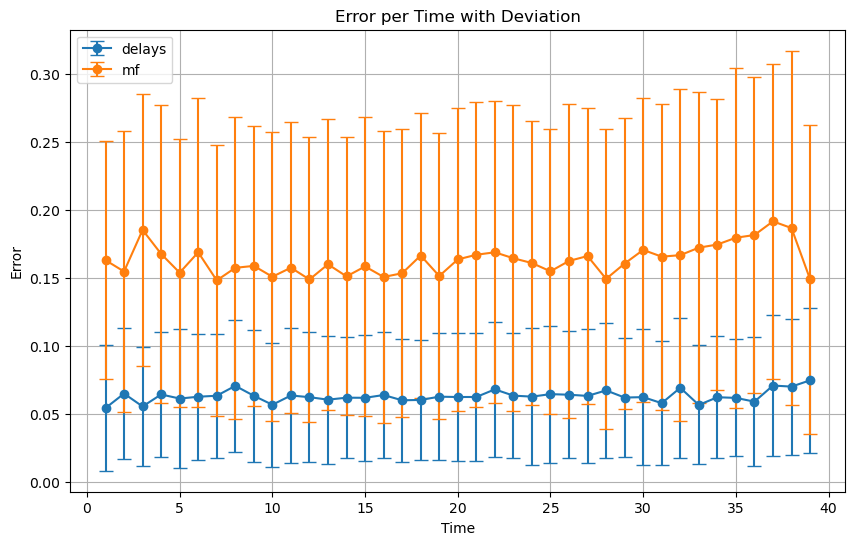

In [31]:
plt.figure(figsize=(10, 6))
plot_error_per_time(errors, 'delays')
plot_error_per_time(errors_mf, 'mf')